<a href="https://colab.research.google.com/github/JoelmirDias/Trabalho/blob/main/dessalgadora_PI_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import joblib
import sys
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#!pip install pythonnet

In [ ]:
sys.path.append(r'C:\Program Files (x86)\PIPC\AF\PublicAssemblies\4.0')

import clr
clr.AddReference('OSIsoft.AFSDK')

from OSIsoft.AF.PI import PIServers, PIPoint
from OSIsoft.AF.Time import AFTime
from OSIsoft.AF.Asset import AFValue
from OSIsoft.AF import Data

In [ ]:
def connect_to_Server(serverName):
    piServers = PIServers()
    global piServer
    piServer = piServers[serverName]
    piServer.Connect(False)

In [ ]:
def get_tag_snapshot(tagname):
    tag = PIPoint.FindPIPoint(piServer, tagname)
    lastData = tag.Snapshot()
    return lastData.Value, lastData.Timestamp

In [ ]:
def put_tag_snapshot(tagname, valor):
    PIValue = AFValue()
    PIValue.Value = valor
    PIValue.Timestamp = AFTime().Now
    tag = PIPoint.FindPIPoint(piServer, tagname)
    tag.UpdateValue(PIValue, Data.AFUpdateOption.Replace)

In [ ]:
TAGS={'SALMOURA':'MOB20501',
      'TI20604':'TI20604',
      'TI20605':'TI20605',
      'Carga':'FIC20667',
      'Densidade':'DENS_U200A_INST',
      'POLI':'MOB20504',
      'DESEM':'MOB20505',
      'pH':'20SAPHP87',
      'LIC20506A':'LIC20506A',
      'LIC20506B':'LIC20506B',
      'LIC20506C':'LIC20506C',
      'LIC20506D':'LIC20506D',
      'PDI20632':'PDI20632',
      'PDI20633':'PDI20633',
      'PDI20502':'PDI20502',
      'PDI20504':'PDI20504'}

In [ ]:
connect_to_Server('S270RAS22')
nomes=[]
valores=[]
dados=pd.DataFrame
for i in TAGS:
    nomes.append(i)
    valor, timestamp = get_tag_snapshot(TAGS[i])
    valores.append(valor)
dicionario_dados = dict(zip(nomes, valores))
dados=pd.DataFrame([dicionario_dados])

,SALMOURA,TI20604,TI20605,Carga,Densidade,POLI,DESEM,pH,LIC20506A,LIC20506B,LIC20506C,LIC20506D,PDI20632,PDI20633,PDI20502,PDI20504
0,CLARA,142.6642,146.761,32022.27,0.902825,INJETA,INJETA,5.2,37.18528,32.92275,55.34066,54.41355,1.137531,1.08813,0.950132,1.117027


## Inicio da condicional

In [ ]:
if dados['SALMOURA'][0]!='CLARA':
    calibra=pd.read_excel('Dados_Exporta.xlsx')
    calibra=pd.concat([calibra,dados]).reset_index().drop(columns='index')

In [2]:
calibra=pd.read_excel('Dados_Exporta.xlsx')

In [3]:
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import pickle

In [4]:
cat_vars=['POLI','DESEM']
for var in cat_vars:
  cat_list = pd.get_dummies(calibra[var], prefix=var)
  calibra = calibra.join(cat_list)

In [5]:
Arraste=[]
for i in range(len(calibra['SALMOURA'])):
  if calibra['SALMOURA'][i]=='CLARA':
    Arraste.append(0)
  elif calibra['SALMOURA'][i]=='TURVA':
    Arraste.append(1)
  else:
    Arraste.append(2)
calibra['Arraste']=Arraste

In [6]:
calibra.drop(columns=['SALMOURA','POLI','DESEM','DESEM_NÃO INJETA','POLI_NÃO INJETA' ], inplace=True)

In [7]:
X = calibra.drop(columns='Arraste')
y = calibra.Arraste

In [8]:
smtom = SMOTETomek(sampling_strategy='all')
x_smtm, y_smtm = smtom.fit_resample(X, y)

In [9]:
crossvalidation=KFold(n_splits=5, shuffle=True, random_state=1)
scorer='accuracy'
max_features=[x_smtm.shape[1]/3, 'sqrt','log2','auto']
min_samples_leaf=[1,10,30]
n_estimators=[50,100,300]
search_grid= {'n_estimators':n_estimators,'max_features': max_features,'min_samples_leaf':min_samples_leaf}
RF = RandomForestClassifier()
melhor_modelo=GridSearchCV(estimator=RF,
                         param_grid=search_grid,
                         scoring=scorer,
                         cv=crossvalidation)
melhor_modelo.fit(x_smtm,y_smtm)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'max_features': [5.0, 'sqrt', 'log2', 'auto'],
                         'min_samples_leaf': [1, 10, 30],
                         'n_estimators': [50, 100, 300]},
             scoring='accuracy')

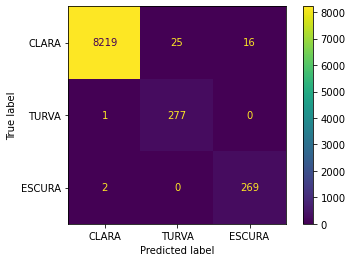

In [10]:
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import ConfusionMatrixDisplay
y_predrealRF=melhor_modelo.predict(X)
mc_realRF=cm(y, y_predrealRF)
mcdrealRF=ConfusionMatrixDisplay(mc_realRF, display_labels=['CLARA','TURVA','ESCURA'])
mcdrealRF.plot()

In [11]:
with open('dessalgadora.pkl', 'wb') as file:
    pickle.dump(melhor_modelo, file)

## Fim da condicional

In [ ]:
if dados['POLI'][0]=='INJETA':
  dados['POLI_INJETA']=1
else:
  dados['POLI_INJETA']=0

if dados['DESEM'][0]=='INJETA':
  dados['DESEM_INJETA']=1
else:
  dados['DESEM_INJETA']=0

In [ ]:
dados.drop(columns=['POLI','DESEM','SALMOURA' ], inplace=True)

In [ ]:
# Carregar modelo
modelo = joblib.load('dessalgadora.pkl')

In [ ]:
ycalc=modelo.predict(dados)

In [ ]:
status=int(ycalc[0])

In [ ]:
status

0

In [ ]:
put_tag_snapshot('U200A_PREDICAO_SALMOURA', status)